# Classer des images à l'aide d'algorithmes de Deep Learning

Nous sommes bénévole pour l'association de protection des animaux de notre quartier. C'est d'ailleurs ainsi que nous avons trouvé notre compagnon idéal, Snooky. Nous nous demandons donc ce que nous pourrions faire en retour pour aider l'association.</br>
Nous apprenons, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.</br>
Nous proposons de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.</br>
Les bénévoles de l'association n'ayant pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs nous utiliserons la bas de données: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

Ce notebook contient le code final à déployer et est exécuter via Kaggle qui offre plus de GPU.

# **Sommaire**

*   **Partie 1:** <a href="#C1">Importation des données</a>
*   **Partie 2:** <a href="#C2">Entraînement du modèle</a>
*   **Partie 3:** <a href="#C3">Pré-processing de l'image en entrée</a>
*   **Partie 4:** <a href="#C4">Prédiction de la race d'un chien</a>
*   **Partie 4:** <a href="#C5">Test du modèle</a>

# <a name="C1">Partie 1: Importation des données</a>
Le **Stanford Dogs Dataset** est déjà présent sur Kaggle. On va donc directement l'utiliser avec les images en couleur pour gagner du temps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import cv2 
import timeit

from PIL import Image
from matplotlib.image import imread
from skimage.transform import resize
from skimage import img_as_ubyte, exposure, color, restoration
from skimage.io import imsave
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten

from keras.applications.xception import Xception
from keras import Model
from keras.models import load_model

In [2]:
#On récupère les uri de chaque image
dogs_lst = []
for file in glob.glob("../input/stanford-dogs-dataset/images/Images/*/*.jpg"):
    dogs_lst.append(file)

#On les stocke dans un dataframe
data = pd.DataFrame(dogs_lst, columns=['uri'])

#On récupère la race du chien
data['breed'] = data['uri'].apply(lambda x: x.split('/')[-2].split('-')[-1])

data.head()

,uri,breed
0,../input/stanford-dogs-dataset/images/Images/n...,otterhound
1,../input/stanford-dogs-dataset/images/Images/n...,otterhound
2,../input/stanford-dogs-dataset/images/Images/n...,otterhound
3,../input/stanford-dogs-dataset/images/Images/n...,otterhound
4,../input/stanford-dogs-dataset/images/Images/n...,otterhound


In [3]:
nb_pictures = len(data)
nb_breeds = len(data['breed'].unique())
print(f"Le jeu de données comporte {nb_pictures} photos de chiens, représentant {nb_breeds} races différentes")

Le jeu de données comporte 20580 photos de chiens, représentant 119 races différentes


# <a name="C2">Partie 2: Entraînement du modèle</a>
On va utiliser le jeu entier pour l'entraînement du modèle et utiliser la Data Augmentation pour augmenter le nombre d'images vues par le modèle et ainsi rééduire les risques d'overfitting.

In [4]:
def prepare_data(df):
    """Fonction qui prend en entrée le dataframe des images et renvoie les 
    données préparées pour le modèle CNN avec data augmentation"""

    #On redimensionne les images
    datagen_aug = image.ImageDataGenerator(rescale=1./255,
                                           rotation_range=10,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           shear_range=0.2,
                                           brightness_range=[0.2,1.2], 
                                           fill_mode="nearest")
  
    train_gen = datagen_aug.flow_from_dataframe(df, 
                                            x_col='uri', 
                                            y_col='breed', 
                                            target_size=(224, 224),
                                            seed=42)

  
    return train_gen

In [5]:
#Données d'entraînement
train = prepare_data(data)
breeds_list = (train.class_indices)
breeds_list = [k for (k,v) in breeds_list.items()]
nb_breeds = len(breeds_list)

Found 20580 validated image filenames belonging to 119 classes.


On sauvegarde la liste des races pour pouvoir faire le matching lors de la prédiction. En effet, la e modèle de prédiction ne renverra que le numéro de la classe, pas le nom de la race.

In [6]:
#Sauvegarde de la liste des races
breeds_list = pd.Series(breeds_list)
breeds_list.to_csv("breeds_list.csv", sep=',', encoding='utf-8')
breeds_list = pd.read_csv("./breeds_list.csv", sep=',', encoding='utf-8')
breeds_list = list(breeds_list.loc[:, '0'])

In [7]:
#Modèle Xception avec fine-tuning partiel
def cnn_ft_partiel(nb_breeds):
    """Fonction qui prend en entrée le nombre de races utilisées
    et renvoie le modèle prêt pour le transfer learning avec fine-tuning partiel"""

    #Charger le modèle pré-entraîné sans les couches fully-connected
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    #Entraîner 10% des couches hautes
    nb_10 = int(len(model.layers)*0.9)
    for layer in model.layers[:nb_10]:
        layer.trainable = False
    for layer in model.layers[nb_10:]:
        layer.trainable = True

    #Définir le nouveau modèle
    new_model = Sequential()
    new_model.add(model)
    new_model.add(GlobalAveragePooling2D())
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(nb_breeds, activation='softmax'))

    return new_model

In [8]:
#Entraînement du modèle
start_time = timeit.default_timer()
cnn = cnn_ft_partiel(nb_breeds)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(train, epochs=50, verbose=0)
time = timeit.default_timer() - start_time

#Sauvegarde du modèle
cnn.save("cnn_final.h5") 
cnn_model = load_model("./cnn_final.h5") 

2022-06-25 19:01:54.040602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 19:01:54.135395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 19:01:54.136178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 19:01:54.137487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


2022-06-25 19:01:59.542953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-25 19:02:03.595309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [9]:
print(time)

16398.764020268


# <a name="C3">Partie 3: Pré-processing de l'image d'entrée</a>
On doit redimensionner l'image en entrée pour pouvoir utiliser le modèle, et également ajouter une dimension pour indiquer qu'il n'y a qu'une seule image passée en entrée.

In [10]:
def prepare_image(img):
    """Fonction qui prend en entrée une image et la prépare pour le modèle de prédiction"""
    
    datagen = image.ImageDataGenerator(rescale=1./255)
    img = np.expand_dims(img, axis=0)
    img = datagen.flow(img)
    
    return img

# <a name="C4">Partie 4: Prédiction de la race d'un chien</a>

In [11]:
def breed_prediction(img):
    """Fonction qui prend en entrée une image de chien et renvoie la prédiction de la race"""
    
    #Préparation de l'image
    img = prepare_image(img)
    
    #Prédiction
    pred = cnn_model.predict(img)
    breed_pred = np.argmax(pred, axis=1)[0]
    breed_proba = round(100*pred[0][breed_pred])
    breed = breeds_list[breed_pred]
    
    #Affichage de la prédiction
    print("Il y a " + str(breed_proba) + "% de chance qu'il s'agisse d'un " + breed)

# <a name="C5">Partie 5: Test du modèle</a>

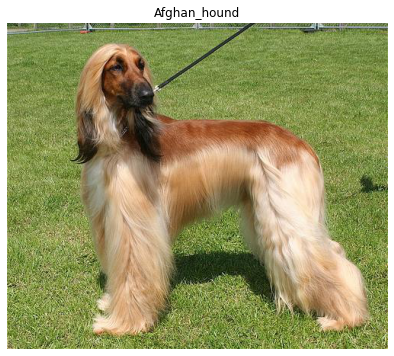

In [12]:
#Test avec une image du jeu d'entraînement
img = imread(data['uri'][500])

#Affichage de l'image
plt.figure(figsize=(10,6))
plt.imshow(img, cmap='gray')
plt.title(data['breed'][500])
plt.axis('off')
plt.show()

In [13]:
breed_prediction(img)

Il y a 92% de chance qu'il s'agisse d'un Afghan_hound


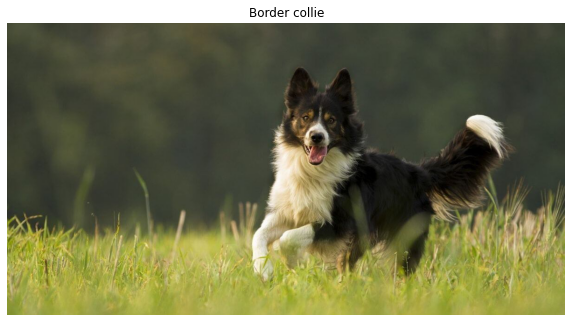

In [14]:
#Test avec une image hors dataset
img = imread("../input/images-chien/border_collie.jpg")

#Affichage de l'image
plt.figure(figsize=(10,6))
plt.imshow(img, cmap='gray')
plt.title("Border collie")
plt.axis('off')
plt.show()

In [2]:
breed_prediction(img)

Il y a 69% de chance qu'il s'agisse d'un border_collie


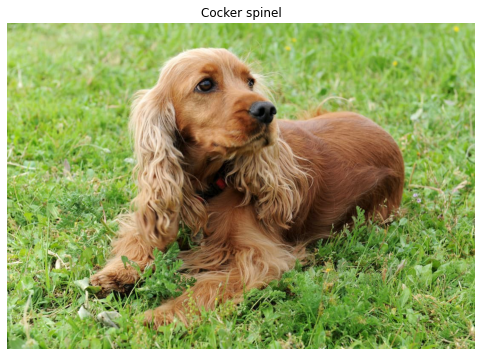

In [16]:
#Test avec une image hors dataset
img = imread("../input/images-chien/cocker_spinel.jpg")

#Affichage de l'image
plt.figure(figsize=(10,6))
plt.imshow(img, cmap='gray')
plt.title("Cocker spinel")
plt.axis('off')
plt.show()

In [1]:
breed_prediction(img)

Il y a 54% de chance qu'il s'agisse d'un cocker_spinel
